In [3]:
import numpy as np
import sys
import time
from multiprocess import Pool
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization



from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.matrices import Matrices, MatricesMetric

INFO: Using numpy backend


In [3]:
from geomstats.geometry.hypersphere import Hypersphere

In [4]:
d=6
sphere = Hypersphere(dim=d)
mfd= sphere.metric


In [5]:
#tau_lst = [0.25,0.5,0.75,1.0,0.125,0.375]

T_lst=[50,100,500]
tau =0
nsamples = T_lst[2]
print(str(tau))
print(str(nsamples))

bp0 = np.array([0,0,0,0,0,0,1])

def generate_sample_tangent_space(base=bp0,n_samples=1,sigma=1):
    # generate i.i.d gaussian noise on tangent space
    size = (n_samples, d) if n_samples != 1 else (1,d)
    
    tangent_vec_aux = sigma*(gs.random.uniform(size=size)-0.5)
    tangent_vec = np.zeros(shape=(n_samples, d+1))
    tangent_vec[:,:d]=tangent_vec_aux
    #sqrt_base_point = gs.linalg.sqrtm(base_point)
    return tangent_vec


def generate_random_sample(base=bp0,n_samples=1,sigma=1):
    # generate sample with Frechet mean equal the given base point.
    tv =  generate_sample_tangent_space(base=base,n_samples=n_samples,sigma=sigma)
    return mfd.exp(tangent_vec=tv,base_point=base)

def generate_ar_ts(base=bp0,n_samples=1,sigma=1,rho=0.5,tau=1,bt=np.array([1,0,0,0,0,0,0]) ):
    # generate AR(1)  process X_t -mu = rho(t/n)(X_{t-1}-mu)+epsilon
    ## rho(u) = 0.3+0.2*u^2
    mut0 =mfd.geodesic(initial_point=base,end_point=bt)
    
    if n_samples ==1:
        return generate_random_sample(base,n_samples=1)
    else:
        data_tv =np.zeros((n_samples, d+1))
        data=np.zeros((n_samples, d+1))
        data_tv[0,:] = generate_sample_tangent_space(base=base,n_samples=1,sigma=sigma)
        data[0] = mfd.exp(tangent_vec=data_tv[0],base_point=base)
        for i in range(1,n_samples):
            u = i/n_samples
            #rhotmp =  0.2*np.cos(2*u*np.pi)+rho+u*(1-u)
            rhotmp = rho+0.5*u*(1-u)
            delta = data_tv[i-1,:]
            
            inten = 1.1*(1+u)*sigma/(1+tau)
            
            noise = generate_sample_tangent_space(base=base,n_samples=1,sigma=sigma/(1+tau))
            noise[0:3] =  inten*noise[0:3]
           # data_tv[i,:]  = rhotmp*delta + noise
            if(tau>0):
                data_tv[i, :] = mfd.parallel_transport(tangent_vec=rhotmp * (delta) + noise, base_point=base,
                                                    end_point=mut0(tau*u))
                data[i] = mfd.exp(tangent_vec= data_tv[i, :], base_point=mut0(tau*u))
            else:
                data_tv[i, :] = rhotmp * (delta) + noise
                                                    
                data[i] = mfd.exp(tangent_vec= data_tv[i, :], base_point=base)
                
        #tvnorm =mfd.inner_coproduct(data_tv,data_tv,base)
       # data =mfd.exp(tangent_vec=data_tv,base_point=base)
        return(data)


def resvec_to_sum(res_vec,w=3):
    # local sum
    dim = res_vec.shape[1]
    N = res_vec.shape[0]
    res =np.zeros((N-w+1,dim))
    for i in range(dim):
        res[:,i] = np.convolve(res_vec[:,i], np.ones(w), 'valid')
    
    return res

def gamma_m(res_vec,w=3):
    localvar = resvec_to_sum(res_vec,w)**2
    n,dim = localvar.shape
    res = np.zeros((n,dim))
    for i in range(dim):
        res[:,i] = np.cumsum(localvar[:,i])/(w*n)
    return(res)


def volatity(res_vec,wlst):
    wm =max(wlst)
    L = len(wlst)
    n,dim = res_vec.shape
    localvar_res=np.zeros(shape=(n-wm+1 ,dim,L))
    for i in range(L):
         localvar_res[:,:,i] = gamma_m(res_vec,wlst[i])[:(n-wm+1),]
    
    vol = np.zeros((n-wm+1, dim,L-2))
    for j in range(n-wm+1):
        for k in range(dim):
            for i in range(L-4):
                vol[j,k,i] = np.std(localvar_res[j,k,i:(i+3)])
    
    vol_sum = np.sum(vol,axis=1)
    
    return np.max(vol_sum,axis=0)

def select_window(res_vec,wlst):
    vol = volatity(res_vec,wlst)
    idx = np.argmin(np.max(vol,axis=0))
    return(wlst[idx+1])


def local_sum(res,w=3):
    # local sum for reisduals
    dim = res.shape[1]
    N = res.shape[0]
    locsum =np.zeros((N-w+1,dim))
    for i in range(dim):
        locsum[:,i] = np.convolve(res[:,i], np.ones(w), 'valid')
    
    return locsum

def Hess(res,mu):
    theta= np.sqrt(mfd.inner_product(res,res,mu))
    u = res/theta
    ftheta=theta/np.sin(theta)
    u = np.reshape(u,(d+1,1))
    x = np.reshape(mu,(d+1,1))
    
    
    H = np.dot(u,np.transpose(u)) + ftheta*np.cos(theta)* (
        np.eye(7)-np.dot(u,np.transpose(u))-np.dot(x,np.transpose(x)))
    return(H)
    

def Hprocess(residual,mean):
    N = residual.shape[0]
    h = np.zeros((N,7,7))
    for i in range(N):
        h[i,:,:] = Hess(residual[i,:],mean)/N
    H = np.cumsum(h,axis=0)
    return(H)

def Hinv(y,mean,H):
    l,v= np.linalg.eig(H)
    lidx = [0,1,2,3,4,5,6]
    lidx.remove(np.argmin(np.abs(l)))
    l = l[lidx]
    v = v[:,lidx]
    invvec = np.zeros(7)
    #invvec
    for k in range(6):
        invvec = mfd.inner_product(y,v[:,k])*v[:,k]/l[k] + invvec
        #mfd.inner_product(y,v[:,1])*v[:,1]/l[1]+mfd.inner_product(y,v[:,0])*v[:,0]/l[0]
    return(invvec)


def generate_Phi(locsum):
    #Philst = np.zeros(locsum.shape)
    n = locsum.shape[0]
    g = np.random.normal(size=n)
    g = g.reshape((n,1))
    dPhi = g*locsum
    Phi = np.cumsum(dPhi,axis=0)
    return Phi



0
500


In [6]:
def bootstrap_test_mp(m):
    
    np.random.seed(m)
    data = generate_ar_ts(base=bp0 ,n_samples=nsamples,sigma=1,rho=0.05,tau=tau) #generate data , mean =id
    residual = data-np.mean(data,axis=0)
    res_cusum =np.cumsum(residual,axis=0)
    res_cusum_norm = np.sqrt(np.sum(res_cusum*res_cusum,axis=1))
    Tn = res_cusum_norm.max()/np.sqrt(nsamples)
    L = max(0.02*nsamples,2)
    U = 0.1*nsamples+1
    windows =np.arange(L,U)
    # windows =np.linspace(0.02, 0.05, num=20) * nsample= 400
    windows = (np.rint(windows)).astype(int)
    w = select_window(residual,windows) 
    B =2000# bootstrap size
    Boot_Stat= np.zeros(B)

    locsum = local_sum(residual,w=w)
    for i in range(B):
        #np.random.seed(seed*10000+i)
        Phi = generate_Phi(locsum)/np.sqrt(w*(nsamples-w+1))
        for k in range(nsamples-w+1):

            Phi[k] = Phi[k]-(k+1)/(nsamples-w+1)*Phi[nsamples-w]

        Phinorm = np.sqrt(np.sum(Phi*Phi,axis=1))

        Boot_Stat[i] = np.max(Phinorm[w:])
    pval =np.mean(Boot_Stat>=Tn) 
    return pval

In [7]:
M =5000
#nsamples= 1000
pval = np.zeros(M)

In [8]:
p=Pool(4)

result = p.map_async(bootstrap_test_mp, range(M))

In [9]:
res = result.get()

In [10]:
for i in range(M):
    pval[i]= res[i]

In [4]:
p1= np.load('Eu_Sphere_pval_debias' +'_tau_'+str(0)+'_T_'+str(50)+'.npy')
p2=np.load('Eu_Sphere_pval_debias' +'_tau_'+str(0)+'_T_'+str(100)+'.npy')
p3= np.load('Eu_Sphere_pval_debias' +'_tau_'+str(0)+'_T_'+str(500)+'.npy')

In [10]:
np.mean(p1<0.05),np.mean(p2<0.05),np.mean(p3<0.05)

(0.3936, 0.9806, 1.0)

In [7]:
import matplotlib.pyplot as plt

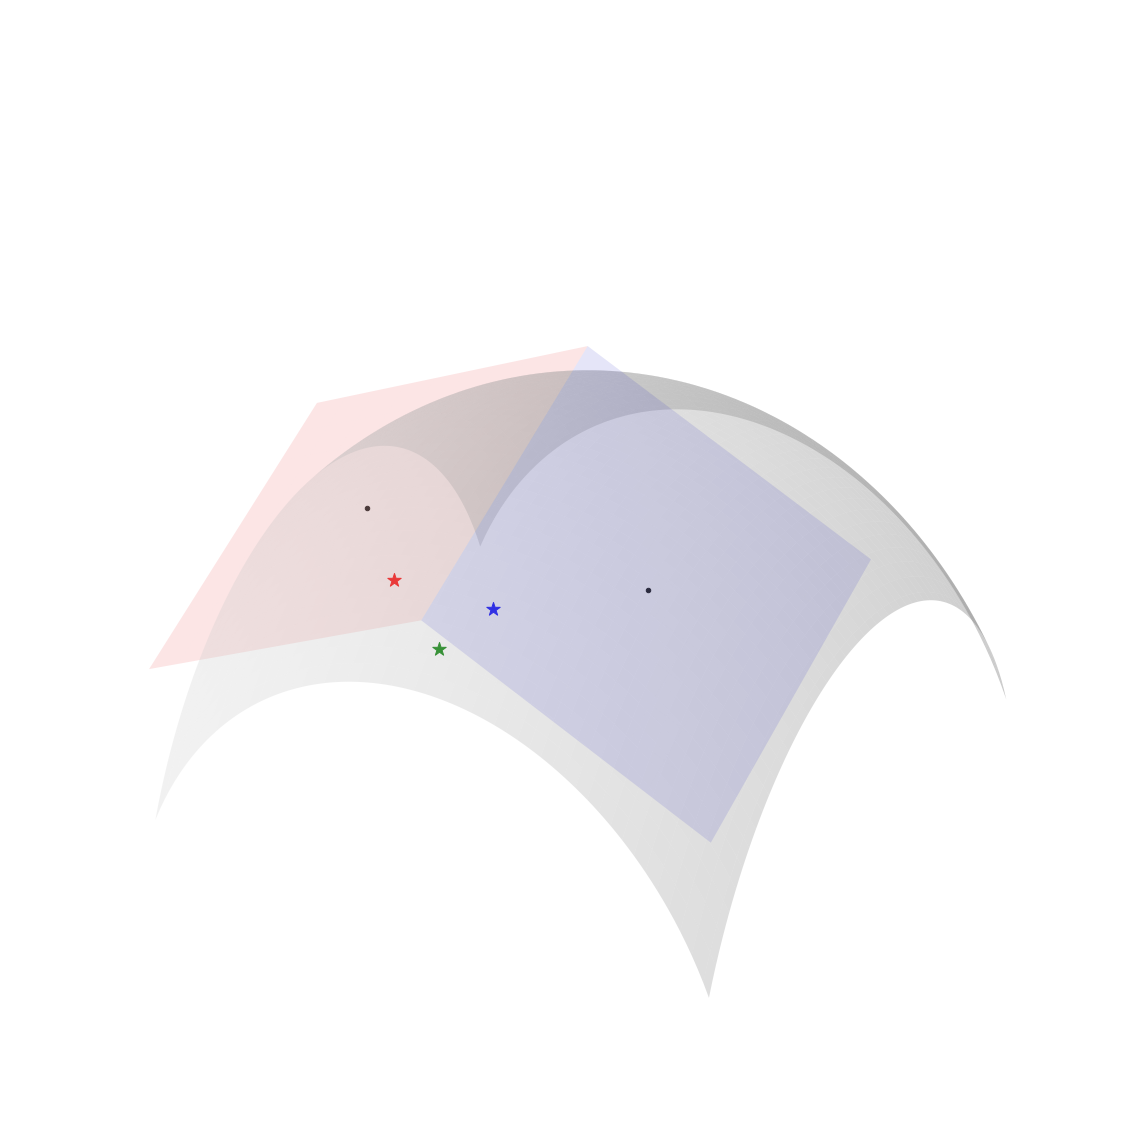

In [69]:
# Adjusting the surface to be the upper hemisphere and selecting closer points

# Define the function for the upper hemisphere
def hemisphere(x, y):
    return np.sqrt(9 - x**2 - y**2)

# Create meshgrid for plotting
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
x, y = np.meshgrid(x, y)
z = hemisphere(x, y)

# Ignore invalid values (outside the hemisphere)
z[np.isnan(z)] = 0

# New points that are closer together
points = [(-1, -1), (1, -1)]

# Adjusting the tangent plane function for the hemisphere
def tangent_plane_hemisphere(x, y, x0, y0):
    z0 = hemisphere(x0, y0)
    dzdx = -x0 / np.sqrt(9 - x0**2 - y0**2)
    dzdy = -y0 / np.sqrt(9 - x0**2 - y0**2)
    return z0 + dzdx * (x - x0) + dzdy * (y - y0)

# Plotting
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the hemisphere
ax.plot_surface(x, y, z, alpha=0.3, color='lightgrey', edgecolor='none')

# Plot the tangent planes for the new points
for l in range(len(points)):
    p = points[l]
    if(l==0):
        cc='red'
    else:
        cc='blue'
    X, Y = np.meshgrid(np.linspace(p[0]-1, p[0]+1, 10), np.linspace(p[1]-1, p[1]+1, 10))
    Z = tangent_plane_hemisphere(X, Y, p[0], p[1])
    ax.plot_surface(X, Y, Z, alpha=0.1, color=cc)
    ax.scatter(p[0], p[1], hemisphere(p[0], p[1]), color='black')

#dat = (0,-1)
ax.scatter(0, -1.8, hemisphere(0, -1.8),color='green',marker='*',s=200)

ax.scatter(0.2, -1.5, hemisphere(0.5, -1.5),color='blue',marker='*',s=200)
ax.scatter(-0.5, -1.5, hemisphere(-0.5, -1.5),color='red',marker='*',s=200)

#process_0 = 

ax.axis('off')
ax.set_xlabel('X axis')

ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.tight_layout()
#ax.set_title('Upper Hemisphere with Tangent Planes at Two Points')
plt.savefig('Tmu.png',facecolor='w')
#plt.show()


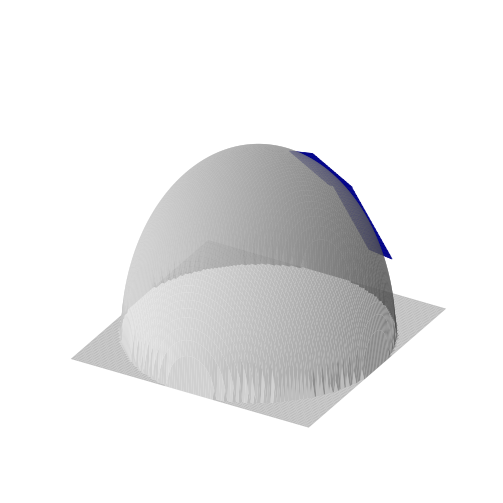

In [15]:
# Enhancing the visualization for a more aesthetic appearance

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d', proj_type='ortho')

# Applying a smooth shading to the hemisphere
ax.plot_surface(x, y, z, alpha=0.7, color='lightgrey', edgecolor='none', rstride=1, cstride=1, shade=True)

# Plotting the tangent planes with a more aesthetic look
for p in points:
    X, Y = np.meshgrid(np.linspace(p[0]-0.5, p[0]+0.5, 20), np.linspace(p[1]-0.5, p[1]+0.5, 20))
    Z = tangent_plane_hemisphere(X, Y, p[0], p[1])
    ax.plot_surface(X, Y, Z, alpha=0.8, color='lightblue', edgecolor='darkblue', rstride=1, cstride=1, shade=True)
    ax.scatter(p[0], p[1], hemisphere(p[0], p[1]), color='black', s=50)

# Hide the axes for a clean and uncluttered look
ax.axis('off')

plt.show()
